# ЗАДАЧА

Для закрепления пройденного материала предлагаем вам следующее задание: используя библиотеку `kaggle-environments`, реализующую функционал взаимодействия между виртуальными агентами в рамках нескольких популярных игр, реализовать самостоятельно несколько агентов и сравнить их в игре «камень-ножницы-бумага».

<img src="https://lms.skillfactory.ru/asset-v1:SkillFactory+MIPTDS+SEPT22+type@asset+block@1200px-Rock-paper-scissors-ru.svg.png" alt="" width="300"/>

# ВАМ НЕОБХОДИМО:
- Описать поведение бота, который будет играть с такими же ботами в игру «камень-ножницы-бумага». Поведение бота описывается с помощью функции, которая принимает на вход информацию о прошлых играх. (сигнатура функции приведена в Google Colab, а детальное описание входящих значений доступно по ссылке)
- После описания поведения агентов запустить турнир между ними и проверить, какая стратегия показывает себя лучше всех.

Отметим, что вам необязательно использовать «качественные» стратегии — в этом задании основной упор необходимо сделать на разнообразие (т.е. агенты, которые бы играли, придерживаясь стратегии «только камень» или »только ножницы» – это нормально).

# Решение

In [1]:
# импорт библиотек
from kaggle_environments import make, evaluate
import numpy as np
import random
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# настройки визуализации
%matplotlib inline
%config InlineBackend.figure_format='retina'

Loading environment lux_ai_2022 failed: No module named 'vec_noise'


In [2]:
# Обозначения для ходов:
# 0 - камень
# 1 - бумага
# 2 - ножницы

## Создаем агентов

Агент # 1 - Агент, который всегда выбирает "камень"

In [3]:
%%writefile agents/rock_agent.py

def rock_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'камень' (0).
    """
    return 0

Writing agents/rock_agent.py


Агент # 2 - Агент, который всегда выбирает "бумагу"

In [4]:
%%writefile agents/paper_agent.py

def paper_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'бумагу' (1).
    """
    return 1

Writing agents/paper_agent.py


Агент # 3 - Агент, который всегда выбирает "ножницы"

In [5]:
%%writefile agents/scissors_agent.py

def scissors_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'ножницы' (2).
    """
    return 2

Writing agents/scissors_agent.py


Агент # 4 - Агент, который копирует последний ход оппонента

In [6]:
%%writefile agents/copy_opponent_agent.py

import random
def copy_opponent_agent(observation, configuration):
    """
    Копирует последний ход противника. Если ход первый, выбирает случайно.
    """
    if observation.step > 0:
        return observation.lastOpponentAction  # копирует предыдущий ход противника
    else:
        return random.randrange(0, configuration.signs)  # случайный ход на первом шаге

Writing agents/copy_opponent_agent.py


Агент # 5 - Агент, который реагирует на последние действия противника

In [7]:
%%writefile agents/reactionary_agent.py

import random
import math

def get_score(left_move, right_move):
    """
    Вычисляет результат последнего действия. 
    Возвращает 0 при ничьей, 1 при выигрыше и -1 при проигрыше.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def reactionary_agent(observation, configuration):
    """
    Агент реагирует на последние действия противника.
    Если предыдущий ход был проигран, выбирает новый ход.
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает следующий ход

    return last_react_action

Writing agents/reactionary_agent.py


Агент # 6 - Агент, который выбирает действие в зависимости от результатов последних ходов

In [8]:
%%writefile agents/counter_reactionary_agent.py

import random
import math


def get_score(left_move, right_move):
    """
    Вычисляет результат последнего действия. 
    Возвращает 0 при ничьей, 1 при выигрыше и -1 при проигрыше.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_counter_action = None
def counter_reactionary_agent(observation, configuration):
    """
    Если агент выиграл, выбирает действие, чтобы противодействовать.
    Иначе адаптируется к ходу противника.
    """
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs  # если выиграл, выбирает контр-ход
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает ход противника + 1

    return last_counter_action

Writing agents/counter_reactionary_agent.py


Агент # 7 - Агент, который анализирует статистику ходов противника

In [9]:
%%writefile agents/statistical_agent.py

import random
action_histogram = {}
def statistical_agent(observation, configuration):
    """
    Запоминает ходы противника и выбирает действие, чтобы противодействовать
    наиболее частому ходу противника.
    """
    global action_histogram
    if observation.step == 0:
        action_histogram = {}  # очищает историю в начале
        return random.randint(0, 2)  # случайный ход в начале
    
    action = observation.lastOpponentAction
    action_histogram[action] = action_histogram.get(action, 0) + 1  # считает ходы противника

    mode_action = max(action_histogram, key=action_histogram.get)  # находит наиболее частый ход
    return (mode_action + 1) % configuration.signs  # возвращает контр-ход

Writing agents/statistical_agent.py


Агент # 8 - Агент Джонсона с анализом паттернов противника

In [10]:
%%writefile agents/Jonson_agent.py

import numpy as np
import collections

def Jonson_agent(observation, configuration):
    """
    Агент с анализом паттернов противника. Использует таблицу частот для предсказания.
    """
    k = 2
    global table, action_seq
    if observation.step % 25 == 0:
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])  # обновляет таблицу каждые 25 шагов
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])  # добавляет последний ход противника
        else:
            action_seq.append(action)
        return action

    key = ''.join([str(a) for a in action_seq[:-1]])  # ключ на основе последовательности ходов
    table[key][observation.lastOpponentAction] += 1  # обновляет таблицу по ключу

    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    key = ''.join([str(a) for a in action_seq[:-1]])
    
    if observation.step < 50:
        next_opponent_action_pred = np.argmax(table[key])  # предсказание по таблице
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())
        
    action = (next_opponent_action_pred + 1) % 3
    if observation.step > 90:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing agents/Jonson_agent.py


Агент # 9 - Агент делающий случайный выбор

In [11]:
%%writefile agents/random_agent.py

import random

def random_agent(observation, configuration):
    """
    Случайный выбор 
    """
    return random.randint(0, 2)

Writing agents/random_agent.py


Агент # 10 - Агент, который случайно выбирает между "камнем" и "бумагой"

In [12]:
%%writefile agents/rock_paper_agent.py

import random

def rock_paper_agent(observation, configuration):
    """
    Случайно выбирает между 'камнем' (0) и 'бумагой' (1).
    """
    return random.randint(0, 1)

Writing agents/rock_paper_agent.py


Агент - # 11. Агент, который случайно выбирает между "бумагой" и "ножницами"

In [13]:
%%writefile agents/paper_scissors_agent.py

import random

def paper_scissors_agent(observation, configuration):
    """
    Случайно выбирает между 'бумагой' (1) и 'ножницами' (2).
    """
    return random.randint(1, 2)

Writing agents/paper_scissors_agent.py


Агент - # 12. Агент, который использует DecisionTreeClassifier (взят [отсюда](https://www.kaggle.com/code/alexandersamarin/decision-tree-classifier))

In [14]:
%%writefile agents/decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    step_mode_features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    step_div_features = np.array([[step // k for step in rollouts['steps']] for k in (100, 150, 250)])
    features = np.concatenate([step_mode_features, step_div_features])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)        
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:        
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)
        
    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Writing agents/decision_tree.py


## Турнир между агентами

### Мое решение

In [15]:
# перечислим агентов
agents = [
    'rock_agent', 
    'paper_agent', 
    'scissors_agent',
    'copy_opponent_agent', 
    'reactionary_agent', 
    'counter_reactionary_agent', 
    'statistical_agent',
    'Jonson_agent', 
    'random_agent',
    'rock_paper_agent', 
    'paper_scissors_agent',
    'decision_tree'
]

# Добавляем путь к каждому агенту
agents_py = ["agents/" + i + ".py" for i in agents]

# создаем все возможные пары агентов
all_agents_combinations = list(combinations(agents_py, 2))

# количество эпизодов
total_episodes = 10
# количество шагов в каждом эпизоде
episode_steps = 100

# записываем результаты встреч
total_results = {}
# записываем количество step
total_episodes_steps = {}

# запускаем указанное количество эпизодов
for i in range(total_episodes):
    # запускаем указаное количество шагов в эпизоде
    for pair in all_agents_combinations:
        # запуск env c настройками
        env = make("rps", configuration={"episodeSteps": episode_steps})
        # получение всех результатов
        total_episode = env.run([pair[0],pair[1]])
        # получаем количество очков 1-го агента
        pair_0_res = total_episode[-1][0]['observation']['reward']
        # получаем количество очков 2-го агента
        pair_1_res = total_episode[-1][1]['observation']['reward']

        # добавляем очки 1-го агента в итоговый словарь с результатами встреч
        total_results[pair[0]] = total_results.get(pair[0],0) + pair_0_res
        # добавляем очки 2-го агента в итоговый словарь с результатами встреч
        total_results[pair[1]] = total_results.get(pair[1],0) + pair_1_res

        # добавляем количество сыгранных step 1-го агента в итоговый словарь с количеством step
        total_episodes_steps[pair[0]] = total_episodes_steps.get(pair[0],0) + episode_steps
        # добавляем количество сыгранных step 2-го агента в итоговый словарь с количеством step
        total_episodes_steps[pair[1]] = total_episodes_steps.get(pair[1],0) + episode_steps

In [16]:
# выведем отсортированные результаты
total_results_srt = {k: v for k, v in sorted(total_results.items(), key=lambda item: item[1], reverse=True)}
total_results_srt

{'agents/decision_tree.py': 5001,
 'agents/reactionary_agent.py': 2784,
 'agents/statistical_agent.py': 2007,
 'agents/Jonson_agent.py': 1453,
 'agents/counter_reactionary_agent.py': 1028,
 'agents/random_agent.py': -62,
 'agents/copy_opponent_agent.py': -102,
 'agents/paper_scissors_agent.py': -415,
 'agents/rock_paper_agent.py': -1145,
 'agents/scissors_agent.py': -2776,
 'agents/paper_agent.py': -3600,
 'agents/rock_agent.py': -4173}

In [17]:
# проверим чтобы у всех агентов было одиноковое количнество проведенных step
total_episodes_steps

{'agents/rock_agent.py': 11000,
 'agents/paper_agent.py': 11000,
 'agents/scissors_agent.py': 11000,
 'agents/copy_opponent_agent.py': 11000,
 'agents/reactionary_agent.py': 11000,
 'agents/counter_reactionary_agent.py': 11000,
 'agents/statistical_agent.py': 11000,
 'agents/Jonson_agent.py': 11000,
 'agents/random_agent.py': 11000,
 'agents/rock_paper_agent.py': 11000,
 'agents/paper_scissors_agent.py': 11000,
 'agents/decision_tree.py': 11000}

### Эталонное решение

In [18]:
# Турнир между агентами
agents = [
    'rock_agent', 
    'paper_agent', 
    'scissors_agent',
    'copy_opponent_agent', 
    'reactionary_agent', 
    'counter_reactionary_agent', 
    'statistical_agent',
    'Jonson_agent', 
    'random_agent',
    'rock_paper_agent', 
    'paper_scissors_agent',
    'decision_tree'
]

# Добавляем путь к каждому агенту
agents_py = ["agents/" + i + ".py" for i in agents]
n_agents = len(agents)

# Инициализируем матрицу результатов
scores = np.zeros((n_agents, n_agents))

# Играем каждый агент против каждого
for i in range(n_agents):
    for j in range(i + 1, n_agents):
        result = evaluate("rps", [agents_py[i], agents_py[j]], configuration={"episodeSteps": 1000}, num_episodes=1)
        scores[i][j] = result[0][0]  # сохраняем результат для агента i
        scores[j][i] = result[0][1]  # сохраняем результат для агента j

# Определяем победителя
vic = []
for i in range(n_agents):
    cnt_vic = sum(1 for j in range(n_agents) if scores[i][j] > 0)  # считаем победы агента
    vic.append(cnt_vic)

# Определяем индексы победителей
i_victors = [i for i, v in enumerate(vic) if v == max(vic)]
if len(i_victors) > 1:
    print("The winners are", '\n', *[agents_py[i] for i in i_victors], "!")
else:
    print("The winner is", agents_py[i_victors[0]], "!")

The winner is agents/decision_tree.py !


,rock_agent,paper_agent,scissors_agent,copy_opponent_agent,reactionary_agent,counter_reactionary_agent,statistical_agent,Jonson_agent,random_agent,rock_paper_agent,paper_scissors_agent,decision_tree
rock_agent,0.0,-999.0,999.0,0.0,-997.0,-499.0,-998.0,-32.0,44.0,-507.0,0.0,-965.0
paper_agent,999.0,0.0,-999.0,0.0,-998.0,-500.0,-998.0,0.0,0.0,506.0,-479.0,-971.0
scissors_agent,-999.0,999.0,0.0,0.0,-999.0,-500.0,-998.0,0.0,0.0,-35.0,529.0,-967.0
copy_opponent_agent,0.0,0.0,0.0,0.0,-500.0,997.0,-201.0,-40.0,0.0,0.0,0.0,-971.0
reactionary_agent,997.0,998.0,999.0,500.0,0.0,-997.0,499.0,22.0,-22.0,236.0,233.0,-965.0
counter_reactionary_agent,499.0,500.0,500.0,-997.0,997.0,0.0,0.0,0.0,-53.0,114.0,106.0,-981.0
statistical_agent,998.0,998.0,998.0,201.0,-499.0,0.0,0.0,0.0,0.0,149.0,43.0,-920.0
Jonson_agent,32.0,0.0,0.0,40.0,-22.0,0.0,0.0,0.0,0.0,0.0,0.0,-41.0
random_agent,-44.0,0.0,0.0,0.0,22.0,53.0,0.0,0.0,0.0,-35.0,0.0,0.0
rock_paper_agent,507.0,-506.0,35.0,0.0,-236.0,-114.0,-149.0,0.0,35.0,0.0,-239.0,-236.0


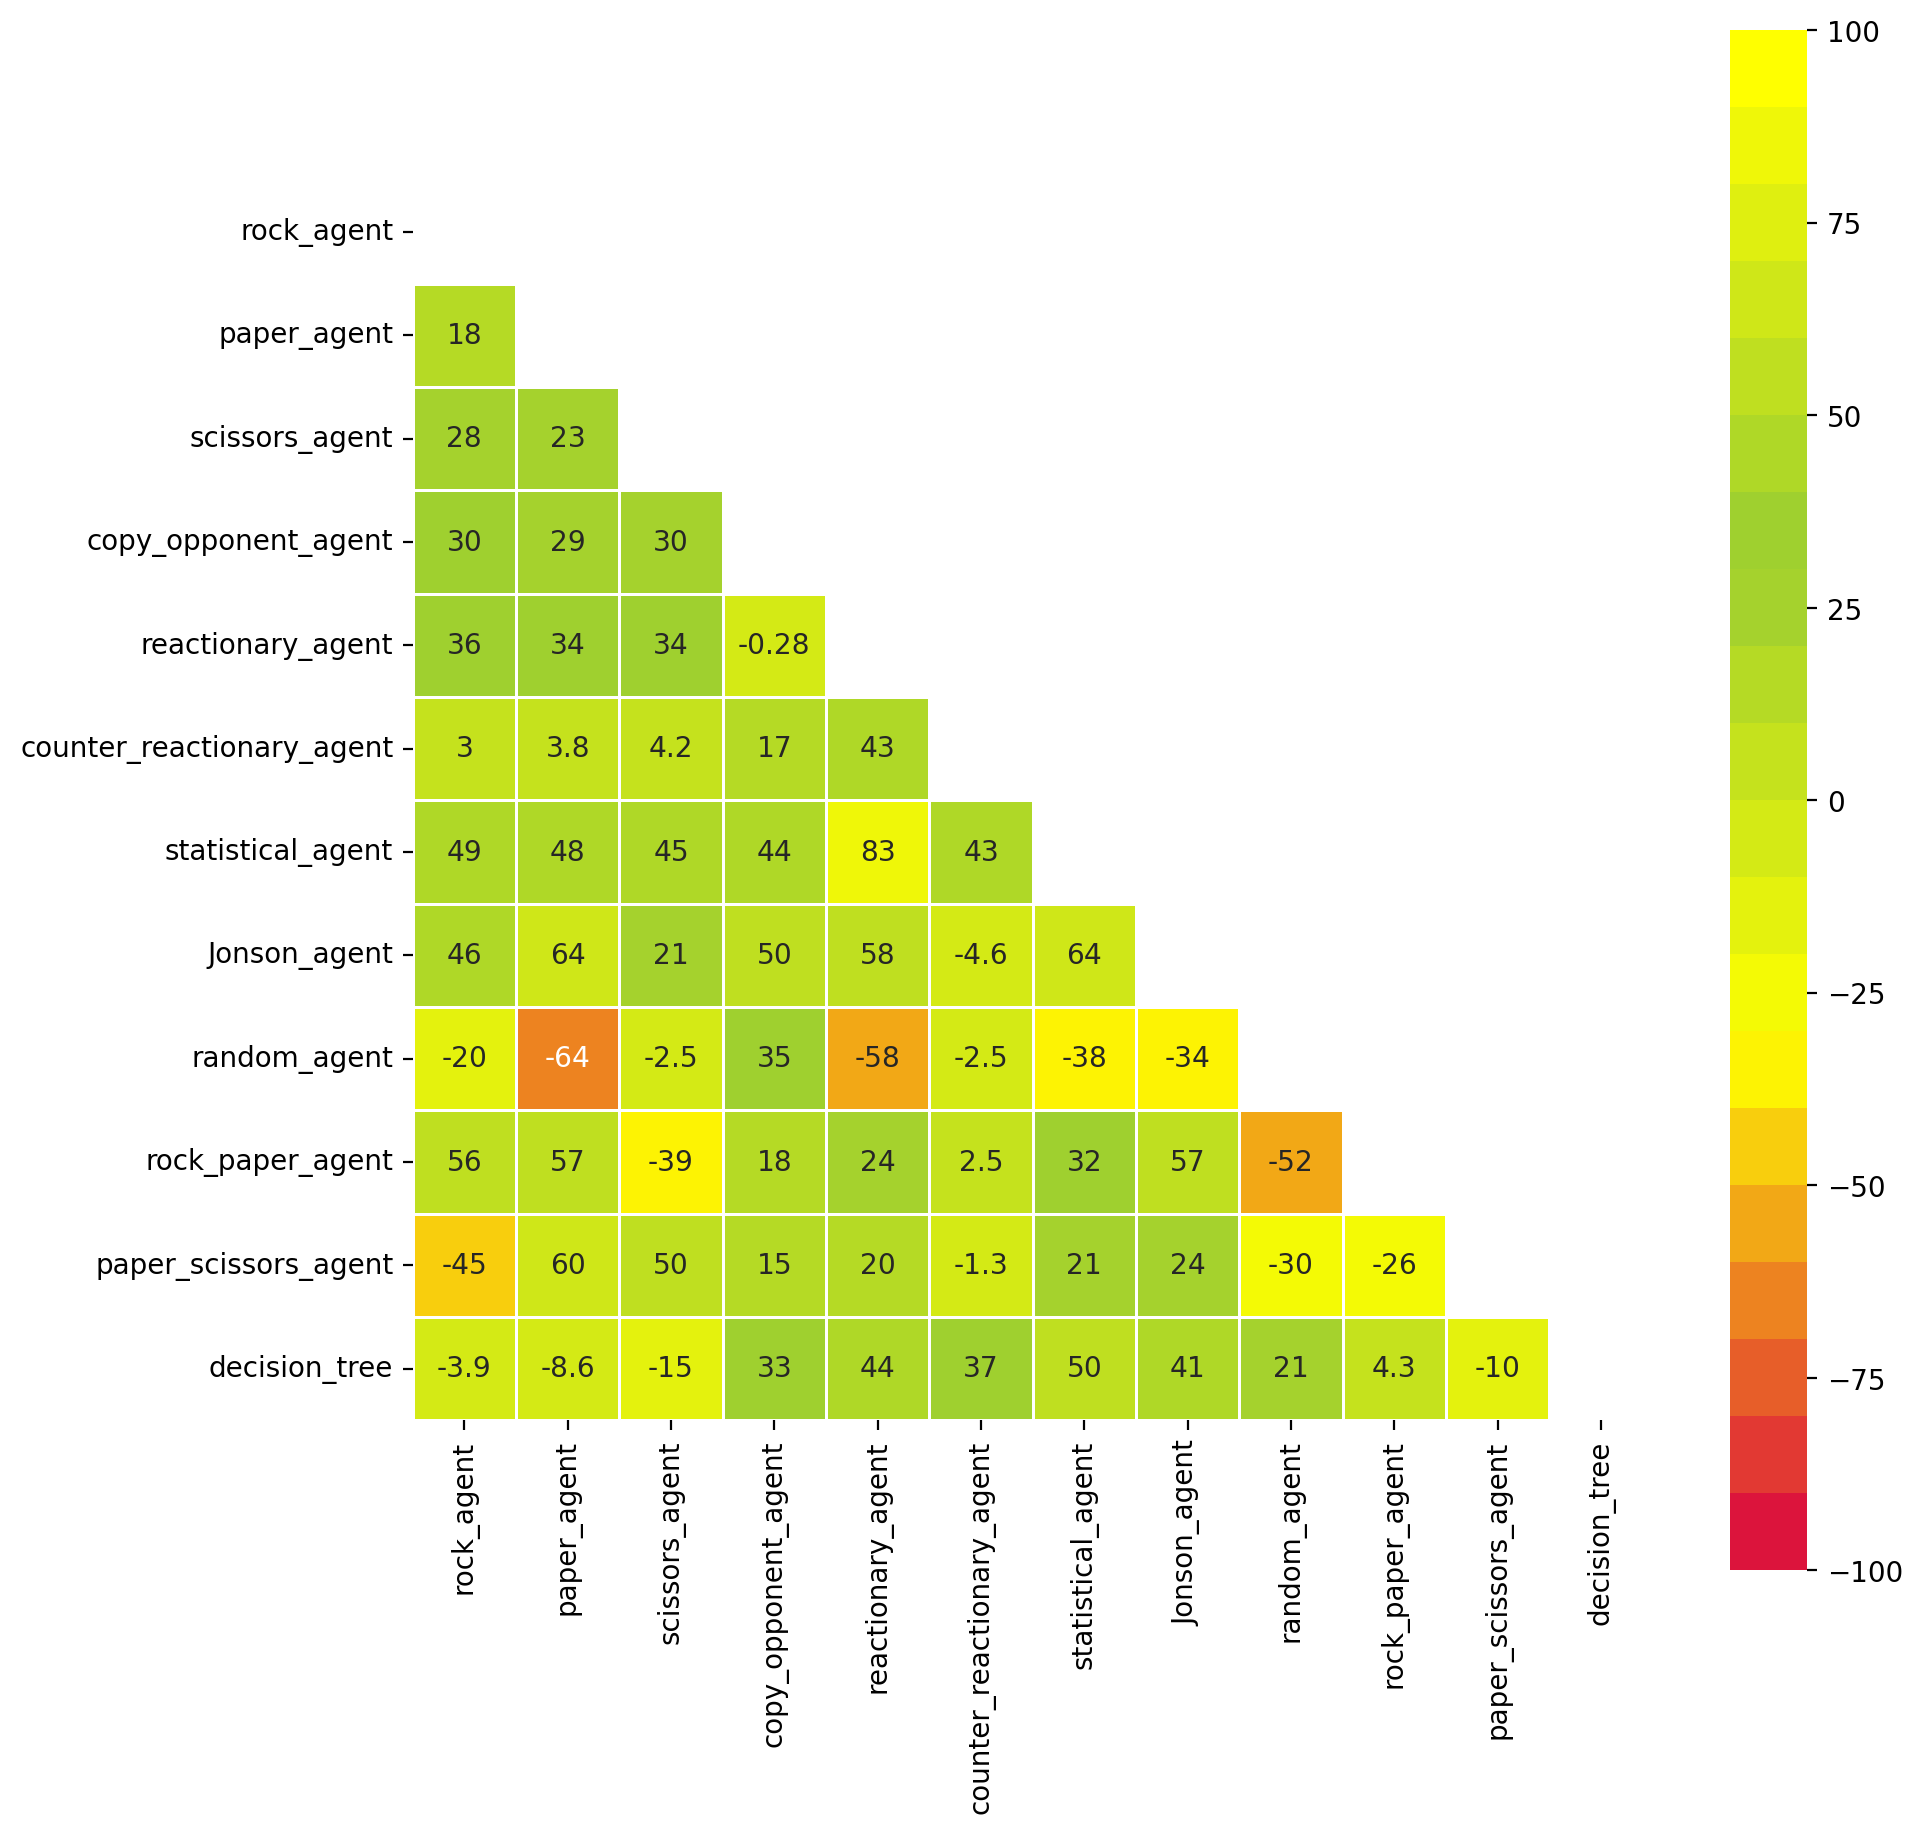

In [19]:
# Построение матрицы корреляций
df_scores = pd.DataFrame(scores, index=agents, columns=agents)
display(df_scores)

# # Построение дополнительной визуализации
import math
from matplotlib.colors import LinearSegmentedColormap

cmatrix = df_scores.corr() * 100
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'yellowgreen', 'yellow'], 20)
mask = np.triu(np.ones(cmatrix.shape[0]), k=0)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(ax=ax, data=cmatrix, cmap=cmap, vmin=-100, vmax=100, linewidths=.5, square=True, annot=True, mask=mask, annot_kws={'size':35 / math.sqrt(cmatrix.shape[0])})
plt.show()

## Визуализация игры (пример)

In [20]:
# Создаем окружение для игры с заданным количеством шагов (ходов)
env = make("rps", configuration={"episodeSteps": 10})

# Дополнительные эксперименты: запуск определенных агентов против друг друга

# Запускаем игру между агентом Jonson и агентом rock
env.run(["agents/Jonson_agent.py", "agents/rock_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат Jonson против rock:", evaluate("rps", ["agents/Jonson_agent.py", "agents/rock_agent.py"], configuration={"episodeSteps": 10}, num_episodes=1))

Результат Jonson против rock: [[0, 0]]


## Выводы:
- было создано 12 агентов (большинство агентов взято из исходного репозитория)
- был проведен турнир между ними, для чего было использовано свое собственное решение и одно из эталонных решений
- выполнен пример визуализации соревнования между агентами
- абсолютный победитель - агент # 12, использующий модель DecisionTreeClassifier
- интересно отметить, что агент выбрасывающий случайый предмет находится в середине итогового списка
- агенты, анализирующие ходы противника, показывают более хорошие результаты, чем те агенты, которые выбрасывают только 1 предмет или случайный из 2-х или 3-х